In [1]:
import os
import tempfile
import time
from ansys.aedt.core import Hfss

AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False
ConvP = 2

temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

project_name = os.path.join(temp_folder.name, "Spherical_Array.aedt")
mode = '10'
design_name = "LP_TM" + mode
hfss = Hfss(version=AEDT_VERSION,
            non_graphical=NG_MODE,
            project=project_name,
            design = design_name,
            new_desktop=True,
            solution_type="Modal",
            )

PyAEDT INFO: Python version 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.16.1.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ITA\AppData\Local\Temp\pyaedt_ITA_29c65af7-7199-4ed7-a381-5533d16b96ee.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT INFO: New AEDT session is starting on gRPC port 57512.
PyAEDT INFO: Electronics Desktop started on gRPC port: 57512 after 40.8193142414093 seconds.
PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64
PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 10872.
PyAEDT INFO: Project Spherical_Array has been created.
PyAEDT INFO: Added design 'LP_TM10' of type HFSS.
PyAEDT INFO: Aedt Objects correctly read


In [2]:
# Variables
hfss["a"] = "100mm"
a = 0.1
hfss["numseg"] = "19"
hfss["h"] = "1.524mm"
h=0.001524

hfss["Dthetaa"] = "43.5363deg"
hfss["Dphia"] = "33.0864deg"
hfss["phip1"] = "96.2368deg"
hfss["thetap1"] = "90deg"

hfss["Rteflon"] = "2.05mm"
Rteflon= 0.00205
hfss["rprobe"] = "0.65mm"
rprobe = 0.00065
hfss["Hprobe"] = "15.07mm"
Hprobe = 0.01507
orange = [255,128,64]
red = [255,0,0]
blue = [0,255,255]

npoints = 9

In [3]:
from pyaedt.modeler.cad.polylines import PolylineSegment

try:
    for i in range(4):
        hfss.modeler.coordinate_systems[0].delete()
    hfss.modeler.set_working_coordinate_system("Global")
except:
    pass
# Generate Geometry
start_point = ["0mm", "0mm", "a"]
center_point = ["0mm", "0mm", "0mm"]

Gnd_Sphere_Name = "Gnd_Sphere"
Gnd_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Gnd_Sphere_Name
)

hfss.modeler.cover_lines(Gnd_Sphere_Name)

hfss.modeler.sweep_around_axis(Gnd_Sphere_Name, "360deg", number_of_segments="2*numseg")

Gnd_Sphere.material_name = "copper"
Gnd_Sphere.color = orange

start_point = ["0mm", "0mm", "a+h"]

Diel_Sphere_Name = "Diel_Sphere"
Diel_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Diel_Sphere_Name
)

hfss.modeler.cover_lines(Diel_Sphere_Name)

hfss.modeler.sweep_around_axis(Diel_Sphere_Name, "360deg", number_of_segments="2*numseg")

Diel_Sphere.material_name = "Arlon AD255A (tm)"

hfss.modeler.subtract(Diel_Sphere_Name, Gnd_Sphere_Name, keep_originals=True)

hfss.modeler.fit_all()

Probe_Sphere_Name = "Patch_Sphere"
Probe_Sphere = hfss.modeler.create_polyline(
    points=[["0mm", "0mm", "a+3*h"], ["0mm", "0mm", "a+3*h"]],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Probe_Sphere_Name
)

hfss.modeler.cover_lines(Probe_Sphere_Name)

hfss.modeler.sweep_around_axis(Probe_Sphere_Name, "360deg", number_of_segments="2*numseg")

hfss.modeler.subtract(Probe_Sphere_Name, [Gnd_Sphere_Name, Diel_Sphere_Name], keep_originals=True)

## Ciclo for
for i in range(1,2):
    Patch_Name = "Patch" + str(i)
    Patch = hfss.modeler.create_polyline(
        points=start_point,
        segment_type=PolylineSegment(
            segment_type="AngularArc",
            arc_center=center_point,
            arc_angle="-180deg",
            arc_plane="ZX",
            num_seg="numseg"
        ),
        name=Patch_Name
    )

    hfss.modeler.sweep_around_axis(Patch_Name, "360deg", number_of_segments="2*numseg")

    hfss["Alpha" + str(i)] = "0deg"
    hfss["Beta" + str(i)] = "0deg"
    hfss["Gamma" + str(i)] = "0deg"

    coord = hfss.modeler.create_coordinate_system(mode = "zxz", origin=center_point, reference_cs="Global",name=Patch_Name+"_CS", phi = "Alpha" + str(i), theta = "Beta"+str(i))

    Cylinder_Name = "Cylinder"+str(i)
    Cylinder = hfss.modeler.create_polyline(
        points=[["0mm","0mm","a+2*h"],["0mm","a+2*h","a+2*h"],["0mm","a+2*h","-a-2*h"],["0mm","0mm","-a-2*h"],["0mm","0mm","a+2*h"]],
        segment_type=[PolylineSegment(
            segment_type="Line",
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        )],
        name=Cylinder_Name
    )
    hfss.modeler.cover_lines(Cylinder_Name)
    hfss.modeler.rotate(Cylinder, "Z", angle="-Dphia/2")
    hfss.modeler.sweep_around_axis(Cylinder_Name, axis="Z", sweep_angle="Dphia-360deg")
    Cylinder.rotate("Y", "Gamma"+str(i))

    Cone_Upper_Name = "Cone_Up_" + str(i)
    Cone_Upper = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","a+2*h"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "-(a+2*h)", name = Cone_Upper_Name)
    Cone_Upper.rotate("Y", "Gamma"+str(i))

    Cone_Lower_Name = "Cone_Down_" + str(i)
    Cone_Lower = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","-(a+2*h)"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "a+2*h", name = Cone_Lower_Name)
    Cone_Lower.rotate("Y", "Gamma"+str(i))

    hfss.modeler.subtract(Patch_Name, [Cylinder_Name, Cone_Lower_Name, Cone_Upper_Name], keep_originals=False)
    hfss.assign_finite_conductivity(Patch_Name)

    Probe_Name = "Probe"+str(i)
    Probe = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h"], radius="rprobe", height="-Hprobe", name = Probe_Name, material="copper")

    Teflon_Name = "Teflon"+str(i)
    Teflon = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h/5"], radius="Rteflon", height="4*h/5-Hprobe", name = Teflon_Name, material="Teflon (tm)")

    hfss.modeler.subtract(Teflon_Name, Probe_Name, keep_originals=True)

    hfss.wave_port(assignment=hfss.modeler[Teflon_Name].faces[0], name = "Wave_Port"+str(i), deembed="Hprobe-h")

    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="thetap1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Z", angle="phip1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="Gamma"+str(i))
    hfss.modeler.subtract(Gnd_Sphere_Name,[Teflon_Name, Probe_Name], keep_originals=True)
    hfss.modeler.subtract(Teflon_Name, Diel_Sphere_Name, keep_originals=True)
    hfss.modeler.subtract(Diel_Sphere_Name, Probe_Name, keep_originals=True)
    hfss.modeler.subtract(Probe_Name, Probe_Sphere_Name, keep_originals=True)

    ###

    hfss.modeler.set_working_coordinate_system("Global")

    hfss.modeler[Patch_Name].color = orange

hfss.modeler.delete(Probe_Sphere_Name)
for obj in hfss.modeler.object_names:
    hfss.modeler[obj].transparency = 0

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 5sec
PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Boundary Finite Conductivity Coating_Patch1 has been created.
PyAEDT INFO: Boundary Wave Port Wave_Port1 has been created.
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Deleted 1 Objects: Patch_Sphere.


In [4]:
freq_range = [1.50042e9, 1.65042e9]      # Frequency range for analysis and post-processing.
center_freq = 1575.42e6            # Center frequency

hfss.create_open_region(frequency=str(center_freq/1e9)+"GHz", boundary = "PML")

setup = hfss.create_setup(name="GPS_Band", Frequency = str(center_freq/1e9)+"GHz", MaximumPasses=20, MinimumPasses=2,MinimumConvergedPasses=ConvP,PercentRefinement=30)

disc_sweep = setup.add_sweep(name="GPS_Discrete", sweep_type="Discrete",
                             RangeStart=str(freq_range[0]/1e9)+"GHz", RangeEnd=str(freq_range[1]/1e9)+"GHz", RangeCount = npoints,
                             SaveFields=True)

hfss.post.update_report_dynamically = True

PyAEDT INFO: Open Region correctly created.
PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Parsing C:/Users/ITA/AppData/Local/Temp/tmpppxt03o3.ansys/Spherical_Array.aedt.
PyAEDT INFO: File C:/Users/ITA/AppData/Local/Temp/tmpppxt03o3.ansys/Spherical_Array.aedt correctly loaded. Elapsed time: 0m 3sec
PyAEDT INFO: aedt file load time 2.9457390308380127
PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


param:  [32.50234913 42.77696647 96.08176891 90.        ]
estim:  [0.02907432 0.01583601 0.01524   ]
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving design setup GPS_Band
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup GPS_Band solved correctly in 0.0h 4.0m 35.0s
pos:  [33.14418144 43.4195324  96.22403134 90.        ]
estim_pos:  [0.03248867 0.01649943 0.0096603 ]
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving design setup GPS_Band
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup GPS_Band solved correctly in 0.0h 6.0m 20.0s


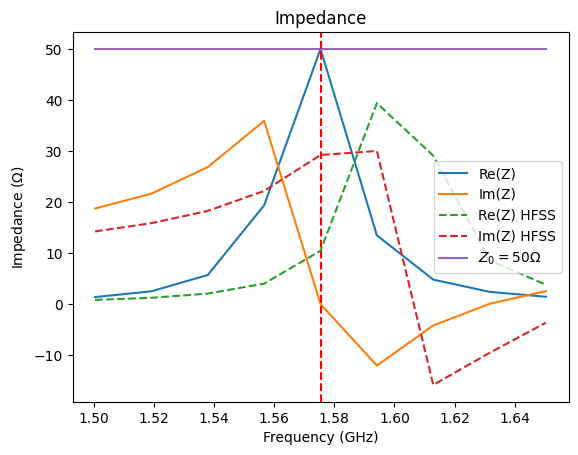

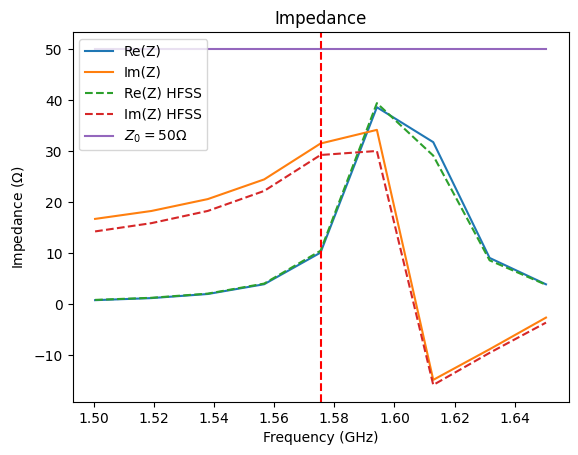

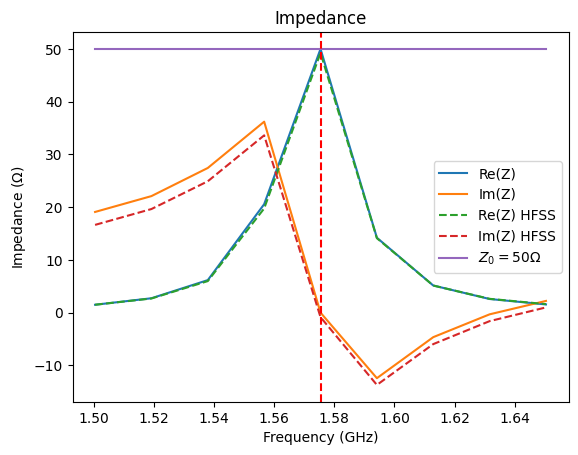

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from Analise_LP import Z_par_g
from Sintese_LP import synth_ant, synth_ant_pos
import pandas as pd
from scipy.optimize import minimize

#freq_range = [1.50042e9, 1.65042e9]
#center_freq = 1575.42e6
#npoints = 11
#mode = '01'

sweep = [freq_range[0], freq_range[1], npoints]
freqs = np.linspace(freq_range[0], freq_range[1], npoints)
rtd = 180/np.pi
Z0 = 50
iT = 0

# I)
param, estim = synth_ant(center_freq, mode)
print('param: ',param*rtd)
print('estim: ',estim)

hfss["Dthetaa"] = str(round(param[0]*rtd,4)) + "deg"
hfss["Dphia"] = str(round(param[1]*rtd,4)) + "deg"
hfss["thetap1"] = str(round(param[2]*rtd,4)) + "deg"
hfss["phip1"] = str(round(param[3]*rtd,4)) + "deg"

# II)
setup.analyze()
try:
    hfss.post.delete_report("Z_11_HFSS_1")
except:
    pass
reportZ = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], setup_sweep_name="GPS_Discrete", plot_name="Z_11_HFSS_1")
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Z_11_HFSS_1")
df = pd.read_csv('Z_11_HFSS_1.csv')
real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

#DphipIt, tgefIt, deltIt = estim[0], estim[1], estim[2]
estimIt = estim

while 1:
    iT +=1
    # III)
    def Z_theory(estimIt):
        Dphip, tgef, delt = estimIt
        return Z_par_g(Dphip, tgef, delt, int(int(mode)/10) % 10, int(mode) % 10, param[0], param[1], param[2], param[3], sweep)

    # IV)
    ZinP = Z_theory(estimIt)
    
    plt.figure()
    plt.plot(freqs / 1e9, np.real(ZinP), label='Re(Z)')
    plt.plot(freqs / 1e9, np.imag(ZinP), label='Im(Z)')
    plt.plot(freqs / 1e9, real_z, label='Re(Z) HFSS', linestyle='--')
    plt.plot(freqs / 1e9, imag_z, label='Im(Z) HFSS', linestyle='--')
    plt.plot(freqs / 1e9, [Z0] * len(freqs), label=r'$Z_0=50\Omega$')
    plt.axvline(x=center_freq / 1e9, color='r', linestyle='--')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Impedance (' + r'$\Omega$' + ')')
    plt.title('Impedance')
    plt.legend()
    #plt.grid(True)
    plt.savefig('impedance_comparison'+str(iT)+'.png', format='png', dpi=300)

    Zhfss = real_z+1j*imag_z
    s11 = 20*np.log10(np.abs((Zhfss-Z0)/(Zhfss+Z0)))

    if (np.argmin(s11)-(npoints-1)/2) == 0 and s11[int((npoints-1)/2)] < -25:
        break

    def cost(params):
        params = np.round(params, 5)
        for i, (low, high) in enumerate([(1e-3, 0.1), (1e-3, 0.1), (1e-3, estim[2])]):
            if not (low <= params[i] <= high):
                return 1e6
        cosRes = np.sqrt(np.sum(((np.real(Z_theory(params)) - real_z) / real_z) ** 2 + ((np.imag(Z_theory(params)) - imag_z) / imag_z) ** 2)) / npoints
        #print(cosRes, params)
        return np.round(cosRes,6)

    #estim[2] *= 3/5
    result = minimize(cost, estimIt, method='nelder-mead')

    estimIt = result.x
    ZinP = Z_theory(estimIt)
    
    plt.figure()
    plt.plot(freqs / 1e9, np.real(ZinP), label='Re(Z)')
    plt.plot(freqs / 1e9, np.imag(ZinP), label='Im(Z)')
    plt.plot(freqs / 1e9, real_z, label='Re(Z) HFSS', linestyle='--')
    plt.plot(freqs / 1e9, imag_z, label='Im(Z) HFSS', linestyle='--')
    plt.plot(freqs / 1e9, [Z0] * len(freqs), label=r'$Z_0=50\Omega$')
    plt.axvline(x=center_freq / 1e9, color='r', linestyle='--')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Impedance (' + r'$\Omega$' + ')')
    plt.title('Impedance')
    plt.legend()
    #plt.grid(True)
    plt.savefig('impedance_post_comparison'+str(iT)+'.png', format='png', dpi=300)

    # V)
    param = synth_ant_pos(center_freq, mode, estimIt)
    print('pos: ', param*rtd)
    print('estim_pos: ', estimIt)
    
    hfss["Dthetaa"] = str(round(param[0]*rtd,4)) + "deg"
    hfss["Dphia"] = str(round(param[1]*rtd,4)) + "deg"
    hfss["thetap1"] = str(round(param[2]*rtd,4)) + "deg"
    hfss["phip1"] = str(round(param[3]*rtd,4)) + "deg"

    setup.analyze()
    reportZ = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], setup_sweep_name="GPS_Discrete", plot_name="Z_11_HFSS_"+str(iT+1))
    hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes",plot_name="Z_11_HFSS_"+str(iT+1))
    df = pd.read_csv('Z_11_HFSS_'+str(iT+1)+'.csv')
    real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
    imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

In [6]:
Rad_3D = hfss.field_setups[0]
print(Rad_3D.name)
Rad_3D.theta_step = "1deg"
Rad_3D.phi_step = "1deg"

#variations = hfss.available_variations.nominal_values
#variations["Freq"] = [center_freq]
#variations["Theta"] = ["All"]
#variations["Phi"] = ["All"]
#axialratio_ffd_plot = hfss.post.create_report(expressions="dB(AxialRatioValue)",
#                                             setup_sweep_name=hfss.nominal_adaptive,
#                                             variations=variations,
#                                             primary_sweep_variable="Theta",
#                                             context="3D",           # Far-field setup is pre-defined.
#                                             report_category="Far Fields",
#                                             plot_type="Rectangular Plot",
#                                             plot_name="Axial Ratio (dB)"
#                                            )

#spar_plot = hfss.create_scattering(plot="Return Loss", sweep=disc_sweep.name)

3D


In [7]:
hfss.save_project()
hfss.release_desktop()

# Wait 5 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(5)

temp_folder.cleanup()

PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Desktop has been released and closed.
